# Global Diferential Privacy Assessement: Bivariate case

In this notebook, we will explore further the bivariate case of the Global Differential Privacy. After running this notebook, you will be able to:
- Understand the concept and applying Gaussian based Global Differential Privacy for bivariate case.

We also run a monte carl simulation to validate the GDP implementation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, wget, shutil, math
from math import sqrt
from scipy.stats import pearsonr
from itertools import combinations
from rich import print as pprint
import warnings, random
warnings.filterwarnings("ignore")
from scipy.stats import multivariate_normal


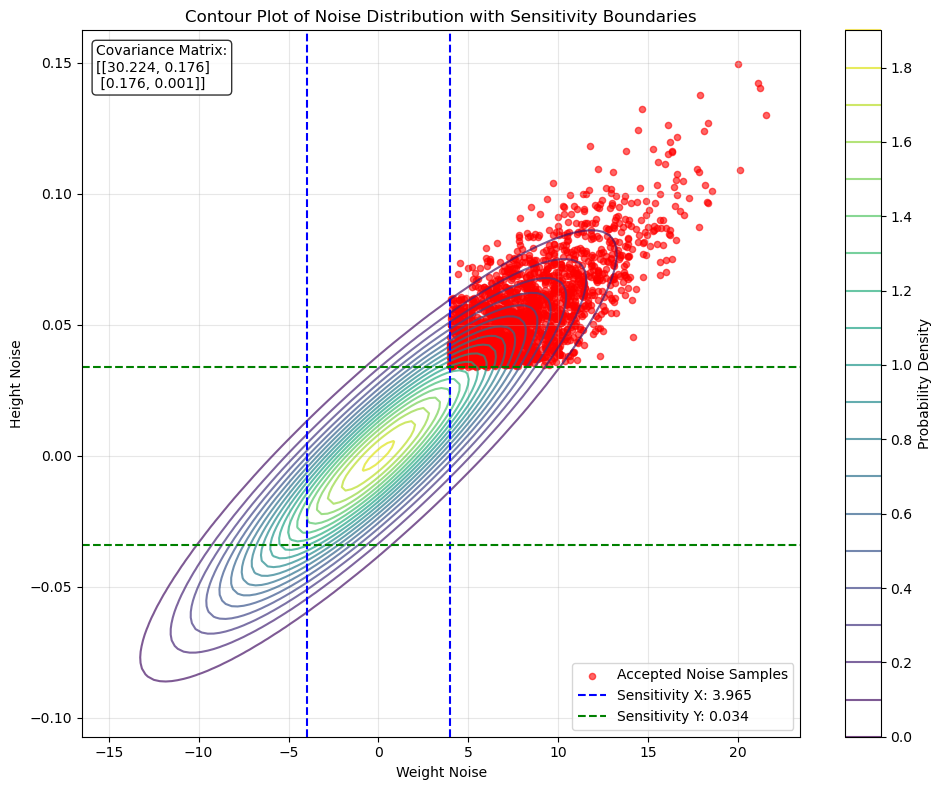

Covariance Matrix:
[[3.02236e+01 1.75950e-01]
 [1.75950e-01 1.27600e-03]]

Sensitivity: [3.965 0.034]

Number of noise samples: 2000


In [173]:
np.random.seed(42)
random.seed(42)

subjects = [{'Weight': round(random.uniform(50, 100), 1),
             'Height': round(random.uniform(1.5, 1.8), 2)} 
            for _ in range(5)]
df = pd.DataFrame(subjects)

def user_output(data):
    return np.array([np.mean(data, axis=0)])

def dp_2d(data, pipeline_output):

    off_d = np.cov([data[:,0],data[:,1]])
    loo_output = np.array([np.mean(np.delete(data,i,axis=0), 0) for i in range(data.shape[0])])
    loo_scale = np.std(loo_output, axis=0)
    sensitivity = np.max(np.abs(loo_output - pipeline_output), 0)
    cov = np.diag((2 * loo_scale)**2) 

    combined = np.abs(np.array(off_d))   
    np.fill_diagonal(combined, np.diag(cov)) 
    noise_samples = []
    for _ in range(2000):
        while True:
            noise = multivariate_normal(mean=[0, 0], cov=combined).rvs()
            if np.all(noise >= sensitivity):
                noise_samples.append(noise)
                break
    
    return np.array(noise_samples), sensitivity, combined

noise_samples, sensitivity, cov = dp_2d(df.values, user_output(df.values))

plt.figure(figsize=(10, 8))

x = np.linspace(-3 * np.sqrt(cov[0, 0]), 3 * np.sqrt(cov[0, 0]), 100)
y = np.linspace(-3 * np.sqrt(cov[1, 1]), 3 * np.sqrt(cov[1, 1]), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

rv = multivariate_normal([0, 0], cov)
Z = rv.pdf(pos)

contour = plt.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
plt.colorbar(contour, label='Probability Density')

plt.scatter(noise_samples[:, 0], noise_samples[:, 1], alpha=0.6, 
           color='red', s=20, label='Accepted Noise Samples')

plt.axvline(x=sensitivity[0], color='blue', linestyle='--', label=f'Sensitivity X: {sensitivity[0]:.3f}')
plt.axvline(x=-sensitivity[0], color='blue', linestyle='--')
plt.axhline(y=sensitivity[1], color='green', linestyle='--', label=f'Sensitivity Y: {sensitivity[1]:.3f}')
plt.axhline(y=-sensitivity[1], color='green', linestyle='--')

plt.xlabel('Weight Noise')
plt.ylabel('Height Noise')
plt.title('Contour Plot of Noise Distribution with Sensitivity Boundaries')
plt.legend(loc=4)
plt.grid(True, alpha=0.3)

cov_text = f'Covariance Matrix:\n[[{cov[0,0]:.3f}, {cov[0,1]:.3f}]\n [{cov[1,0]:.3f}, {cov[1,1]:.3f}]]'
plt.text(0.02, 0.98, cov_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("Covariance Matrix:")
print(cov)
print(f"\nSensitivity: {sensitivity}")
print(f"\nNumber of noise samples: {len(noise_samples)}")

we’re sampling 2D noise, but only keeping the samples that are “big enough” to mask the sensitivity in both dimensions. That’s why the cloud of red points is kind of shifted away from the center and packed into the allowed region.

This plot shows how the bivariate noise distribution behaves once we move from the univariate case to two dimensions (Weight on x-axis and Height Noise on the y-axis).

- The elliptical contours are the probability density of the multivariate Gaussian, basically where noise values are most likely to land.
- The red dots are the actual noise samples we accepted. Notice they’re all pushed into the top-right corner, because of the sensitivity rules.
- The blue dashed lines mark the sensitivity threshold for the x dimension (3.97) as well as the green lines do the same for the y dimension (0.034).

The covariance matrix in the corner shows how strongly the two dimensions of noise are linked. Since the off-diagonal values aren’t zero, the noise in one dimension is correlated with the other.

# Bivariate Differential Privacy
Here is an extension of the previous 1D (univariate) version to 2D data where we extend from Height to Weight. The rest of the setup is as previous notebooks.

In [248]:
from numpy.random import multivariate_normal
subjects = [{'Weight': round(random.uniform(50, 100), 1),
             'Height': round(random.uniform(1.5, 1.8), 2)} 
            for _ in range(5)]
df = pd.DataFrame(subjects)

def user_output(data):
    return np.array([np.mean(data, axis=0)])

def dp_2d(data, pipeline_output):

    off_d = np.cov([data[:,0],data[:,1]])
    loo_output = np.array([np.mean(np.delete(data,i,axis=0), 0) for i in range(data.shape[0])])
    loo_scale = np.std(loo_output, axis=0)
    sensitivity = np.max(np.abs(loo_output - pipeline_output), 0)
    cov = np.diag((2 * loo_scale)**2) 

    combined = np.abs(np.array(off_d))   
    np.fill_diagonal(combined, np.diag(cov)) 
    while True:
        noise = multivariate_normal(mean=[0, 0], cov=combined)#.rvs()
        if np.all(noise >= sensitivity):
            break
    noisy_output = pipeline_output + noise
    
    return noisy_output, sensitivity

def iqr_bounds(data, axis=0):

    data = np.asarray(data)
    q1 = np.percentile(data, 25, axis=axis)
    q3 = np.percentile(data, 75, axis=axis)
    
    iqr = q3 - q1
    lower_bounds = q1 - 1.5 * iqr
    upper_bounds = q3 + 1.5 * iqr
    
    return iqr, lower_bounds, upper_bounds

def outlier_(value, lower_bounds, upper_bounds):

    value = np.asarray(value)
    lower_bounds = np.asarray(lower_bounds)
    upper_bounds = np.asarray(upper_bounds)
    
    return (value < lower_bounds) | (value > upper_bounds)
#def outlier_(value, lower, upper):
    
#    return np.all(value < lower) or np.all(value > upper)


# Validation

We use Monte Carlo simulations to show that the 2D results are differentially private.
Since GDP depends on the influence of a single observation, we generate 1000 datasets of size 20, 40, 60, 80, and 100 with one injected outlier. For each replicate, the query is the 2D leave-one-out mean, which without noise would allow reconstruction of individual data points (see notebook 1). By adding multivariate noise, we prevent such reconstruction and make outlier identification impossible.

We then evaluate:

- The ability (or inability) to detect the outlier in 2D space.
- The accuracy of reconstructed 2D means relative to sensitivity.

In [5]:
def sim_2d(n_replicates, subsample_sizes, OL=True):    
    id_dr = {size: np.zeros(size) for size in subsample_sizes}  
    counts = {size: 0 for size in subsample_sizes}
    reconstructed = {size: [] for size in subsample_sizes}
    true_means_ = {size: [] for size in subsample_sizes}
    sensitivities_ = {size: [] for size in subsample_sizes}
    error_ = {size: [] for size in subsample_sizes}
    
    for n in range(n_replicates):
        subjects = [{'Weight': round(random.uniform(50, 100), 1),
                     'Height': round(random.uniform(1.5, 1.8), 2)} 
                    for _ in range(200)]
        df = pd.DataFrame(subjects)

        for size in subsample_sizes:
            subsample = df.iloc[:size].copy()

            if OL:
                subsample.iloc[0, subsample.columns.get_loc("Weight")] = 10.0 
                subsample.iloc[0, subsample.columns.get_loc("Height")] = 10.0 
            else:
                pass

            true_mean = user_output(subsample)  
            true_means_[size].append(true_mean)
            loo_data = [subsample.drop(index=i) for i in range(len(subsample))]
            
            noisy_outputs = []
            sens_outputs = []

            for loo_subset in loo_data:
                output = user_output(loo_subset)
                noisy_output, sensitivity_ = dp_2d(np.array(loo_subset), output)
                noisy_outputs.append(noisy_output)
                sens_outputs.append(sensitivity_)
            noisy_outputs = np.array(noisy_outputs)   
            coeff_mat = np.ones((size, size)) - np.eye(size)
            recons = []

            for dim in range(noisy_outputs.shape[1]): 
                recons_dim = np.linalg.solve(coeff_mat, (size - 1) * noisy_outputs[:, dim])
                recons.append(recons_dim)
            recons = np.stack(recons, axis=1) 
            
            reconstructed[size].append(recons)
            sensitivities_[size].append(sens_outputs)

            subsample_array = subsample[['Weight', 'Height']].to_numpy()
            recons_error = np.mean(np.linalg.norm(recons - subsample_array, axis=1))
            error_[size].append(recons_error)
            
            iqr_, lower_b, upper_b = iqr_bounds(recons[:,0])
                
            for idx in range(size):
                if np.all(outlier_(np.array(recons[idx,0]), np.array(lower_b), np.array(upper_b))):
                    id_dr[size][idx] += 1
                    
    return id_dr, counts, reconstructed, sensitivities_, error_




In [7]:
n_replicates = 1000
subsample_sizes = [20, 40, 60, 80, 100]

id_dr_OL, counts_OL, reconstructed_OL, sensitivities_OL, error_OL = sim_2d(n_replicates, subsample_sizes, OL=True)
id_dr, counts, reconstructed, sensitivities_, error_ = sim_2d(n_replicates, subsample_sizes, OL=False)

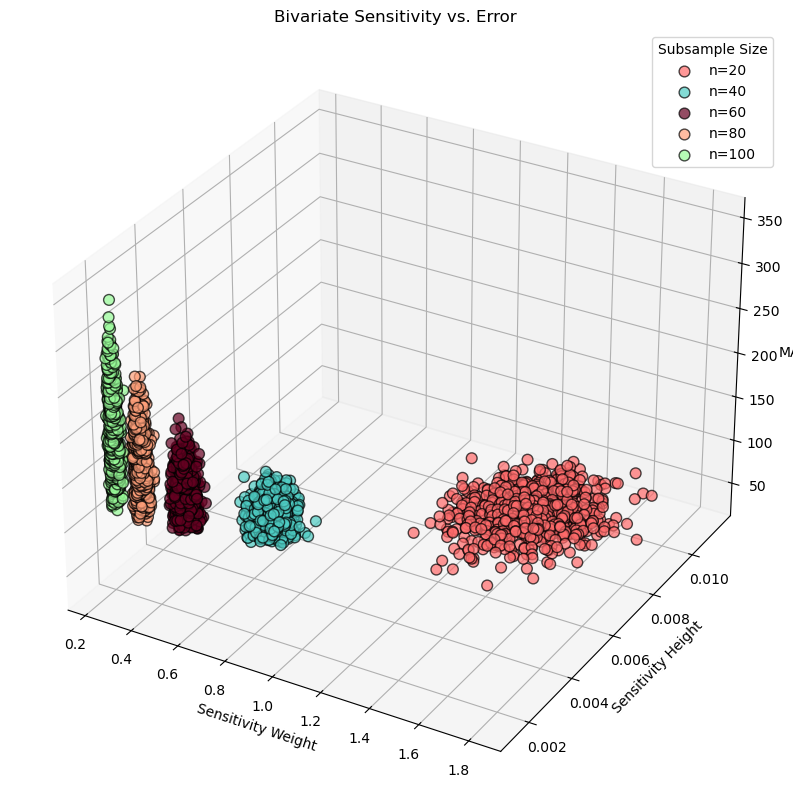

In [9]:
color_map = {
    20: '#FF6B6B',
    40: '#4ECDC4',
    60: '#650021',
    80: '#FFA07A',
    100: '#98FB98',
 }

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

for size in subsample_sizes:
    ax.scatter(np.mean(sensitivities_[size],1)[:,0], np.mean(sensitivities_[size],1)[:,1], np.array(error_[size]),
               color=color_map[size],
               s=60, alpha=0.7, edgecolors='k',
               label=f'n={size}')

ax.set_xlabel("Sensitivity Weight")
ax.set_ylabel("Sensitivity Height")
ax.set_zlabel("MAE")
ax.set_title("Bivariate Sensitivity vs. Error")
ax.legend(title="Subsample Size")
plt.show()


# Sensitivity Vs. MAE

This 3D plot shows the relationship between bivariate sensitivity (for weight and height) and the reconstruction error across different sample sizes.

- X-axis (Sensitivity Weight) and Y-axis (Sensitivity Height) show how sensitive each dimension is to the removal of one individual (leave-one-out).
- Z-axis (Error) measures how much error there is when trying to reconstruct the data after noise is added.


### What we see:

- Smaller datasets, like n=20, have higher sensitivity and higher reconstruction error, meaning outliers have a bigger influence.
- The same behaviour as 1D, as sample size increases, sensitivity in both dimensions shrinks, and reconstruction error stabilizes (clusters get tighter and lower).

Overall, the plot shows that in the 2D case, larger datasets protect privacy better (lower sensitivity) while keeping reconstruction error bounded.

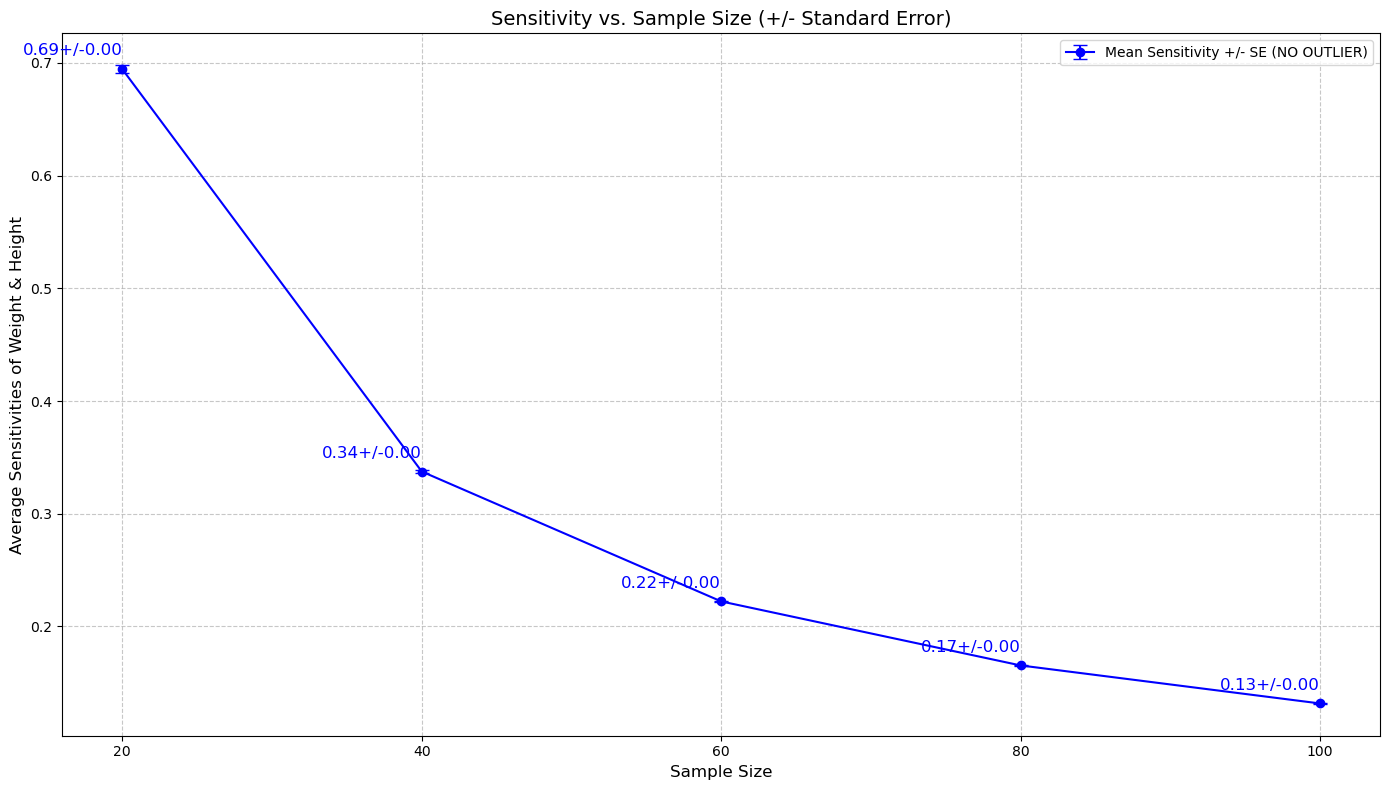

In [63]:
mean_sensitivities = list()
std_errors = list()

for size in subsample_sizes:
    all_sensitivities = np.array(sensitivities_[size]).flatten()
    mean_sens = np.mean(all_sensitivities)
    std_err = np.std(all_sensitivities) / np.sqrt(len(all_sensitivities))
    mean_sensitivities.append(mean_sens)
    std_errors.append(std_err)
    
plt.figure(figsize=(14, 8))

plt.errorbar(
    subsample_sizes, mean_sensitivities, yerr=std_errors,
    fmt='o-', capsize=5, color='blue',
    label='Mean Sensitivity +/- SE (NO OUTLIER)'
)


for size, sens, err in zip(subsample_sizes, mean_sensitivities, std_errors):
    plt.annotate(
        f"{sens:.2f}+/-{err:.2f}", 
        (size, sens),
        textcoords="offset points", 
        xytext=(0, 10),
        ha='right', 
        fontsize=12,
        color='blue'
    )


plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('Average Sensitivities of Weight & Height', fontsize=12)
plt.title('Sensitivity vs. Sample Size (+/- Standard Error)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(subsample_sizes)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

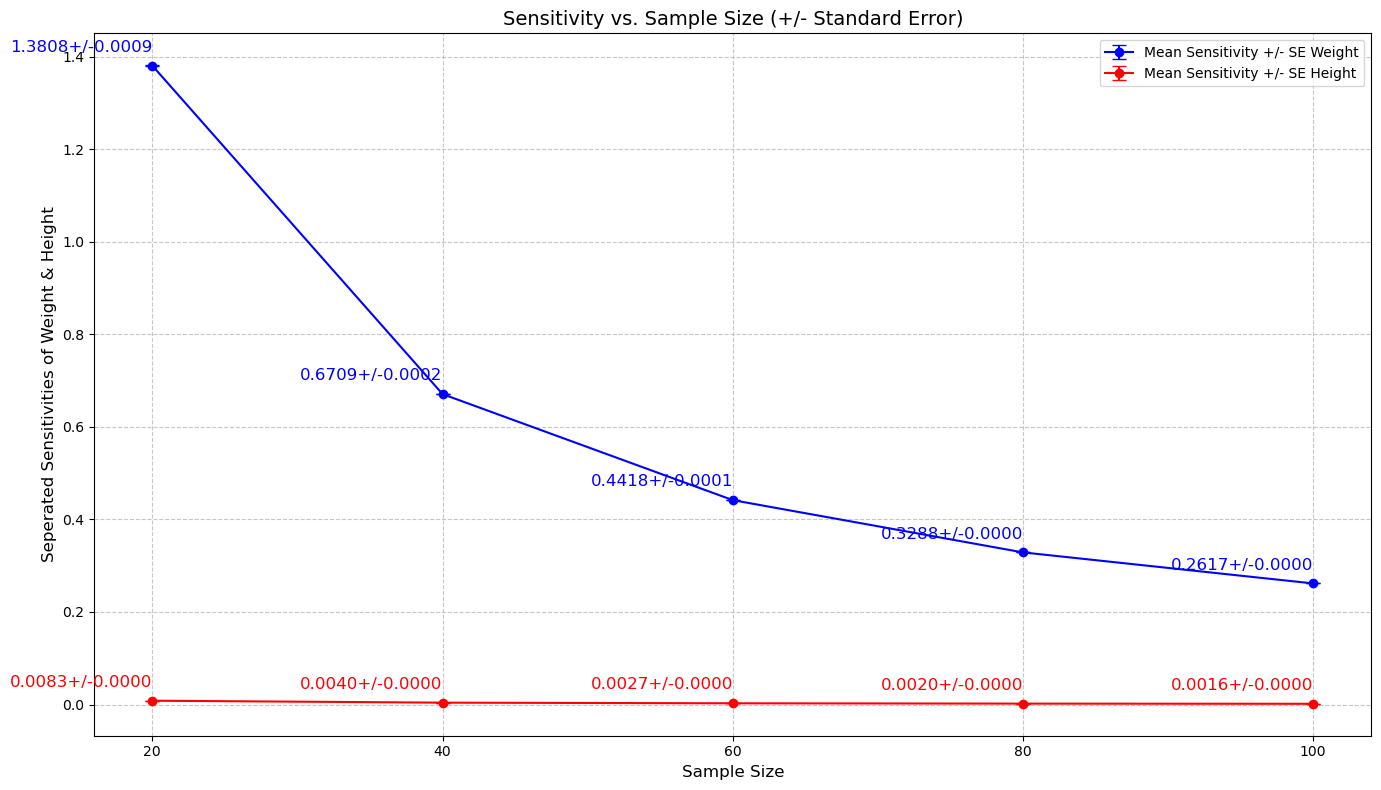

In [64]:
plt.figure(figsize=(14, 8))

mean_sens_w, mean_sens_h = list(), list()
std_err_w, std_err_h = list(), list()

for size in subsample_sizes:
    w_sens_all = np.array(sensitivities_[size])[0:,:,0].flatten()
    h_sens_all = np.array(sensitivities_[size])[0:,:,1].flatten()
    w_sens = w_sens_all.mean()
    h_sens = h_sens_all.mean()
    
    w_std_err = np.std(w_sens_all) / np.sqrt(len(w_sens_all))
    h_std_err = np.std(h_sens_all) / np.sqrt(len(h_sens_all))
    
    mean_sens_w.append(w_sens)
    mean_sens_h.append(h_sens)
    
    std_err_w.append(w_std_err)
    std_err_h.append(h_std_err)
    
plt.errorbar(
    subsample_sizes, mean_sens_w, yerr=std_err_w,
    fmt='o-', capsize=5, color='blue',
    label='Mean Sensitivity +/- SE Weight'
)
for size, sens, err in zip(subsample_sizes, mean_sens_w, std_err_w):
    plt.annotate(
        f"{sens:.4f}+/-{err:.4f}", 
        (size, sens),
        textcoords="offset points", 
        xytext=(0, 10),
        ha='right', 
        fontsize=12,
        color='blue'
    )

plt.errorbar(
    subsample_sizes, mean_sens_h, yerr=std_err_h,
    fmt='o-', capsize=5, color='red',
    label='Mean Sensitivity +/- SE Height'
)  

for size, sens, err in zip(subsample_sizes, mean_sens_h, std_err_h):
    plt.annotate(
        f"{sens:.4f}+/-{err:.4f}", 
        (size, sens),
        textcoords="offset points", 
        xytext=(0, 10),
        ha='right', 
        fontsize=12,
        color='red'
    )
plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('Seperated Sensitivities of Weight & Height', fontsize=12)
plt.title('Sensitivity vs. Sample Size (+/- Standard Error)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(subsample_sizes)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

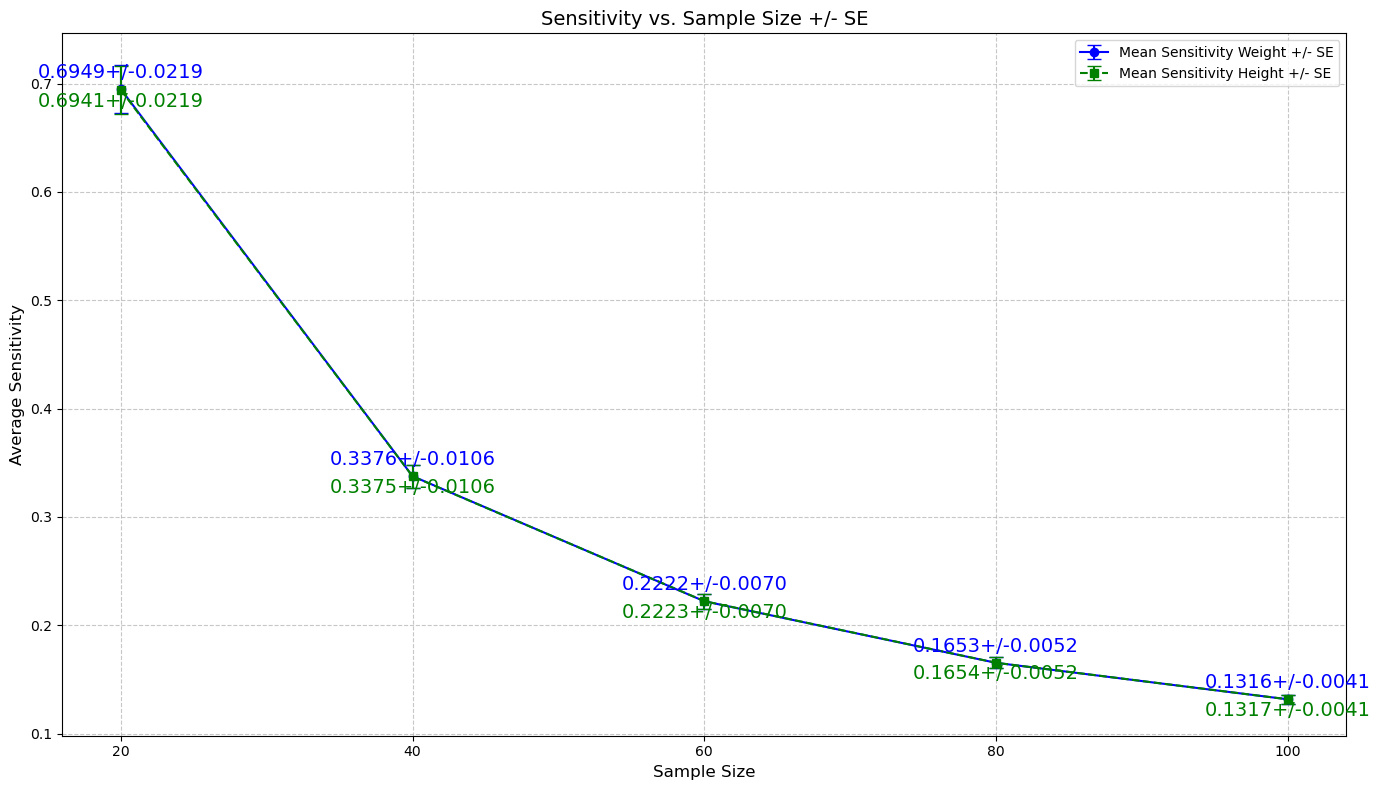

In [11]:
mean_sens1 = []
mean_sens2 = []
std_err1 = []
std_err2 = []

for size in subsample_sizes:
    sens = np.array(sensitivities_[size]) 
    mean_sens1.append(np.mean(sens[:, 0]))
    mean_sens2.append(np.mean(sens[:, 1]))
    std_err1.append(np.std(sens[:, 0]) / np.sqrt(len(sens)))
    std_err2.append(np.std(sens[:, 1]) / np.sqrt(len(sens)))

plt.figure(figsize=(14, 8))

plt.errorbar(
    subsample_sizes, mean_sens1, yerr=std_err1,
    fmt='o-', capsize=5, color='blue',
    label='Mean Sensitivity Weight +/- SE'
)

plt.errorbar(
    subsample_sizes, mean_sens2, yerr=std_err2,
    fmt='s--', capsize=5, color='green',
    label='Mean Sensitivity Height +/- SE'
)

for size, s1, e1, s2, e2 in zip(subsample_sizes, mean_sens1, std_err1, mean_sens2, std_err2):
    plt.annotate(f"{s1:.4f}+/-{e1:.4f}", (size, s1),
                 textcoords="offset points", xytext=(0, 8),
                 ha='center', fontsize=14, color='blue')
    plt.annotate(f"{s2:.4f}+/-{e2:.4f}", (size, s2),
                 textcoords="offset points", xytext=(0, -12),
                 ha='center', fontsize=14, color='green')

plt.xlabel("Sample Size", fontsize=12)
plt.ylabel("Average Sensitivity", fontsize=12)
plt.title("Sensitivity vs. Sample Size +/- SE", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(subsample_sizes)
plt.legend(fontsize=10, loc="best")

plt.tight_layout()
plt.show()


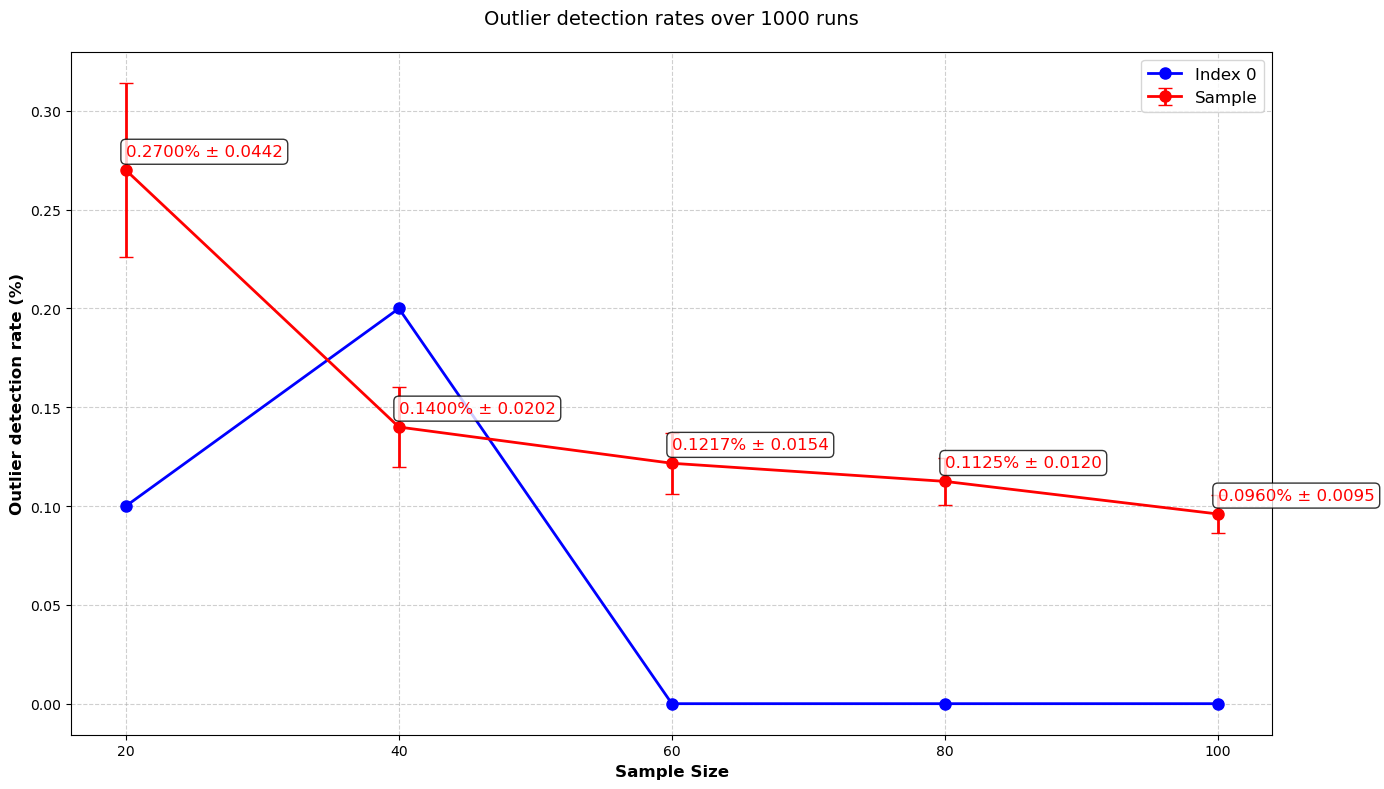

In [60]:
detection_rates = (np.array([id_dr[size][0] for size in subsample_sizes], dtype=object) / n_replicates ) * 100 
prc = (np.array([id_dr[size][0] for size in subsample_sizes], dtype=object) / n_replicates ) * 100

means = []
errors = []
pop_size = []

for size in subsample_sizes:
    percentages = (id_dr[size] / n_replicates) * 100
    mean_val = np.mean(percentages)
    se_val = np.std(percentages, ddof=1) / np.sqrt(len(percentages))
    means.append(mean_val)
    errors.append(se_val)
    pop_size.append(size)

plt.figure(figsize=(14, 8))
plt.plot(subsample_sizes, detection_rates, 
         marker='o', linestyle='-', color='blue', label='Index 0', linewidth=2, markersize=8)

for size in subsample_sizes:
    if size in detection_rates:
        rate = detection_rates[size]
        plt.annotate(f"{rate:.4f}%", (size, rate),
                     textcoords="offset points", xytext=(0, 10),
                     ha='right', fontsize=12, color='blue')

plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, 
             color='red', label='Sample', linewidth=2, markersize=8, elinewidth=2)

for x, y, err in zip(pop_size, means, errors):
    plt.annotate(f"{y:.4f}% ± {err:.4f}",
                 xy=(x, y), xytext=(0, 10),
                 textcoords='offset points', ha='left',
                 fontsize=12, color='red',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel('Sample Size', fontsize=12, fontweight='bold')
plt.ylabel('Outlier detection rate (%)', fontsize=12, fontweight='bold')
plt.title(f'Outlier detection rates over {n_replicates} runs', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(subsample_sizes)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

In [66]:
print(f"NO OUTLIER: ")
id_dr

NO OUTLIER: 


{20: array([1., 8., 3., 0., 2., 1., 5., 2., 0., 2., 4., 5., 4., 2., 2., 0., 4.,
        3., 3., 3.]),
 40: array([2., 0., 0., 2., 1., 1., 3., 0., 3., 1., 3., 0., 1., 0., 1., 1., 1.,
        0., 4., 0., 4., 1., 1., 1., 0., 3., 2., 0., 0., 3., 1., 3., 2., 2.,
        4., 1., 2., 2., 0., 0.]),
 60: array([0., 1., 1., 0., 4., 2., 0., 4., 0., 2., 2., 3., 1., 1., 2., 3., 0.,
        3., 3., 2., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 4., 0., 4., 1.,
        0., 1., 2., 1., 3., 2., 0., 1., 2., 2., 1., 2., 1., 1., 0., 1., 1.,
        0., 0., 0., 2., 1., 0., 1., 0., 0.]),
 80: array([0., 0., 1., 0., 2., 1., 0., 0., 2., 0., 0., 0., 1., 2., 2., 3., 2.,
        0., 0., 1., 1., 1., 2., 0., 1., 4., 0., 1., 2., 2., 3., 1., 1., 0.,
        2., 1., 1., 2., 0., 1., 0., 0., 0., 0., 1., 0., 1., 4., 2., 2., 2.,
        1., 2., 2., 0., 1., 2., 0., 1., 1., 1., 2., 2., 3., 0., 0., 2., 0.,
        1., 3., 0., 0., 2., 2., 0., 1., 4., 0., 1., 1.]),
 100: array([0., 1., 1., 1., 1., 1., 0., 0., 2., 1., 1., 2., 0.,

In [67]:
print(f"WITH OUTLIER: ")
id_dr_OL

WITH OUTLIER: 


{20: array([0., 0., 0., 1., 2., 1., 1., 2., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
        2., 1., 3.]),
 40: array([0., 2., 1., 2., 2., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 2.,
        1., 0., 1., 2., 1., 0., 1., 1., 0., 1., 2., 0., 0., 1., 1., 0., 0.,
        0., 0., 3., 2., 1., 0.]),
 60: array([0., 0., 0., 1., 0., 0., 0., 3., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 2., 1., 0., 0., 0., 2., 0., 0., 2., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 1.]),
 80: array([0., 2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 1., 4., 0.,
        0., 1., 2., 0., 1., 0., 2., 0., 0., 2., 0., 0., 0., 1., 0., 1., 2.,
        1., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0.]),
 100: array([0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 3., 0., 1.,